In [1]:
print("Importing Libraries ...", end = " ")
try:
    import numpy as np
    import pandas as pd
    import random
    import h5py
    import time
    import mne
    import csv
    import os
    from sklearn.preprocessing import scale, minmax_scale, StandardScaler
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import BaggingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import model_selection, svm, metrics
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.utils import shuffle
    from scipy.signal import butter, lfilter, freqz
    from datetime import datetime, timedelta
    from matplotlib.patches import Rectangle
    from matplotlib import pyplot as plt
    from scipy.stats import skew, kurtosis
    from scipy import fftpack
    from scipy import signal
    import pywt
    
    import tensorflow as tf
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
    from model_dtct_feat import get_model
    from model_dtct_reeg import get_model_reeg
    from model_dtct_cnn_feat import get_model_cnn_feat
    from model_dtct_cnn_reeg import get_model_cnn_reeg
    print("Done!\n")
except Exception as e:
    print("Failed to import one or more packages!\n")
    print(e)
    
print(tf.config.list_physical_devices("GPU"))
print(tf.__version__)

Importing Libraries ... 

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2024-11-26 14:36:27.385327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 14:36:27.592130: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 14:36:28.416820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lclhome/umoha

Done!

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [2]:
def butterworth_lowpass_filter(signal_data, sampling_rate = 256.0, cutoff_frequency = 127.0, filter_order = 5):
    normalized_cutoff = 2 * cutoff_frequency / sampling_rate
    b, a = butter(filter_order, normalized_cutoff, btype='low', analog=False)   
    filtered_signal = np.zeros(signal_data.shape)
    for i in range(signal_data.shape[0]):
        filtered_signal[i,:] = lfilter(b, a, signal_data[i,:])
    return filtered_signal

def butterworth_bandpass_filter(signal_data, sampling_rate = 256.0, cutoff_frequency = [0.5, 127.0], filter_order = 5):
    normalized_cutoff_1 = 2 * cutoff_frequency[0] / sampling_rate
    normalized_cutoff_2 = 2 * cutoff_frequency[0] / sampling_rate
    normalized_cutoff = [normalized_cutoff_1, normalized_cutoff_2]
    
    # Design the Butterworth low-pass filter
    b, a = butter(filter_order, normalized_cutoff, btype='pass', analog=False)
    
    filtered_signal = np.zeros(signal_data.shape)
    # Apply the filter to the signal
    for i in range(signal_data.shape[0]):
        #print(i+1, end = " ")
        filtered_signal[i,:] = lfilter(b, a, signal_data[i,:])

    return filtered_signal

def fft_mit(x, fs): 
    N = len(x) # find the length of the signal
    X_fft = fftpack.fft(x) # perform the fast Fourier transform (fft)
    X_fft_shifted = fftpack.fftshift (X_fft) # shift zero frequency components
    freq = np.arange (-N/2, N/2)*fs/N # compute the frequencies for the output
    X_mag = np.abs( X_fft_shifted )/N # compute the magnitudes of the signal
    X_phi = np. angle ( X_fft_shifted ) # compute the phases of the signal
    # ----- End of user defined function ----- #
    return freq, X_mag, X_phi

def make_stem (ax ,x,y, color ='k',style ='solid',label ='',linewidths =2.5 ,** kwargs ):
    ax. axhline (x[0] ,x[ -1] ,0 , color ='r')
    ax. vlines (x, 0 ,y, color =color , linestyles =style , label =label , linewidths = linewidths )
    ax. set_ylim ([1.05* y. min () , 1.05* y. max () ])

def list_mean(list_1):
    return sum(list_1)/len(list_1)

def return_feature_list(array_work, samp_rate = 256, num_of_channels = 20):
    total_feature_list = []
    for ch_count in range(num_of_channels):
        freq, X_mag, _ = fft_mit(array_work[:,ch_count], fs = samp_rate)
        total_mags = 8
        mag_ratios = 7
        total_mag_ratios = total_mags+mag_ratios*total_mags
        half_idx = len(X_mag)//2
        bin_size = half_idx//8 
        mag_list = [0]*total_mags
        mag_list_ratios = [0]*total_mag_ratios
        for ii in range(total_mags):
            strt_idx = half_idx+ii*bin_size
            ends_idx = strt_idx+bin_size
            mean_spectrum = np.mean(X_mag[strt_idx:ends_idx])
            mag_list[ii] = mean_spectrum 
            mag_list_ratios[ii] = mean_spectrum
        for ii in range(total_mags):
            counts = 0
            for jj in range(total_mags):
                if not ii == jj:
                    ratio_of_mags = mag_list[ii]/(mag_list[jj]+np.finfo(float).eps)
                    curr_idx = total_mags+ii*mag_ratios+counts
                    mag_list_ratios[curr_idx] = ratio_of_mags
                    counts+=1
        mag_list_ratios.append(np.mean(array_work[:,0]))
        mag_list_ratios.append(np.var(array_work[:,0]))

        wvlt = pywt.wavedec(array_work[:,0], 'db5', mode='sym', level=4)
        for ii in range(len(wvlt)):
            mag_list_ratios.append(np.mean(wvlt[ii]))
    
        total_feature_list += mag_list_ratios
    return(total_feature_list)

In [3]:
def print_seizure_distribtion(y_in = np.random.randint(0, 2, (100,)), description = "Training"):
    print("{} Class Distribution --> \t Non-Seizure: {}\t Seizure: {}".format(description, 
                                                                              y_in.shape[0]-np.sum(y_in), 
                                                                              np.sum(y_in)))
    
def ftrext_wrapper(X_input, num_of_features = 1633, description =  "Training", verbose = True,
                   time_dtct_feat_ex_dict = {"Training": []}, time_dtct_avrg_feat_ex_dict = {"Training": []}):
    if verbose:
        print(f"{description} data ...", end = "\r")
    t_start = time.time()
    feat_extr_array = np.zeros((len(X_input), num_of_features))
    for index in range(len(X_input)):
        array_work = X_input[index]
        temp_feat_list = return_feature_list(array_work)
        feat_extr_array[index,:] = temp_feat_list
    t_end = time.time()
    time_dtct_feat_ex_dict[description].append(t_end-t_start)
    time_dtct_avrg_feat_ex_dict[description].append((t_end-t_start)/len(feat_extr_array))
    if verbose:
        print(100*" ", end = "\r")
        print(f"{description} feature array shape:{feat_extr_array.shape}")
    return feat_extr_array

def read_hdf_data(file_path, description = "Input", type = "features", verbose = "True"):
    try:
        X_input_read_hdf = h5py.File(file_path,'r')
        X_input_read = X_input_read_hdf['tracings']
        X_input = np.array(X_input_read)
        if verbose:
            print(f'{description} set {type} array shape: ', X_input.shape)
        X_input_read_hdf.close()
        return X_input
    except:
        print(f"Could not read {description} data.")
        return None
    
def write_hdf_data(file_path, X_input):
    try:
        X_data_hdf = h5py.File(file_path,'w')
        X_data_hdf.create_dataset('tracings', data = X_input)
        X_data_hdf.close()
    except:
        print("Could not write data")

def classifier_selection(class_key = "ada"):
    if class_key == "log":
        return LogisticRegression(class_weight='balanced', max_iter = 1000)
    elif class_key == "svm":
        return svm.SVC(kernel='rbf', C=3, gamma = 'scale', probability = True, 
                       class_weight='balanced', max_iter = 1000)
    elif class_key == "nvb":
        return GaussianNB()
    elif class_key == "knn":
        return KNeighborsClassifier(n_neighbors = 3, weights = 'distance')
    elif class_key == "dtr":
        return DecisionTreeClassifier(max_depth = 6, random_state = 42, 
                                         class_weight='balanced')
    elif class_key == "lda":
        return LinearDiscriminantAnalysis(shrinkage=None)
    elif class_key == "rfc":
        return RandomForestClassifier(max_depth=6, random_state=0, 
                                         class_weight = "balanced")
    elif class_key == "ada":
        return AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
    elif class_key == "bag":
        return BaggingClassifier(base_estimator = DecisionTreeClassifier(), 
                                    n_estimators=10, random_state=0)
    elif class_key == "gbc":
        return GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                             max_depth=6, random_state=0)
    else:
        print("Invalid classifier requested, returning Logistic Regression!")
        return LogisticRegression(class_weight='balanced', max_iter = 1000)

def dl_mdl_cls_selection(class_key = "res"):
    pass
    
def train_and_test_ml(dkey, class_key, run_number, X_train, y_train, X_valid, y_valid, X_test, y_test, 
                      results_path, time_trad_ml_dict, time_avrg_trad_ml_dict):
    trn_rslt_fname = f'{results_path}{dkey}_trn_pred_{class_key}_feat_output.npy'
    vld_rslt_fname = f'{results_path}{dkey}_vld_pred_{class_key}_feat_output.npy'
    tst_rslt_fname = f'{results_path}{dkey}_tst_pred_{class_key}_feat_output.npy'
    classifier = classifier_selection(class_key)
    
    t_start = time.time()
    classifier.fit(X_train,y_train)
    t_end = time.time()
    time_trad_ml_dict[dkey][class_key][0] = t_end-t_start
    time_avrg_trad_ml_dict[dkey][class_key][0] = (t_end-t_start)/y_train.shape[0]
    
    t_start = time.time()
    y_prob = classifier.predict_proba(X_test)
    t_end = time.time()
    time_trad_ml_dict[dkey][class_key][1] = t_end-t_start
    time_avrg_trad_ml_dict[dkey][class_key][1] = (t_end-t_start)/y_valid.shape[0]
    
    t_start = time.time()
    y_hat = classifier.predict(X_test)
    t_end = time.time()
    time_trad_ml_dict[dkey][class_key][2] = t_end-t_start
    time_avrg_trad_ml_dict[dkey][class_key][2] = (t_end-t_start)/y_test.shape[0]

    print(f"The training accuracy: {classifier.score(X_train,y_train)*100:.2f}%") 
    print(f"The validation accuracy: {classifier.score(X_valid,y_valid)*100:.2f}%") 
    print(f"The test accuracy: {classifier.score(X_test,y_test)*100:.2f}%") 
    y_prob_train = classifier.predict_proba(X_train)[:,-1].reshape(-1,1)
    y_prob_valid = classifier.predict_proba(X_valid)[:,-1].reshape(-1,1)
    y_prob_test = classifier.predict_proba(X_test)[:,-1].reshape(-1,1)
    print("Saving results ...", end = " ")
    np.save(trn_rslt_fname, y_prob_train)
    np.save(vld_rslt_fname, y_prob_valid)
    np.save(tst_rslt_fname, y_prob_test)
    print("Done!\n")

In [4]:
def dl_mdl_cls_selection(class_key = "res", num_of_classes = 2):
    if class_key == "cnn":
        return get_model_cnn_feat(num_of_classes)
    elif class_key == "res":
        return get_model(num_of_classes)
    elif class_key == "rnn":
        return GaussianNB()
    else:
        print("Invalid classifier requested, returning Logistic Regression!")
        return LogisticRegression(class_weight='balanced', max_iter = 1000)

def train_and_test_dl(dkey, class_key, run_number, X_train, y_train, X_valid, y_valid, X_test, y_test, 
                      results_path, time_pred_feat_dl_dict, time_avrg_pred_feat_dl_dict,
                      lr = 1e-3, batch_size = 32, epochs = 25, loss = 'binary_crossentropy'):
    opt = Adam(lr)
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=lr / 100), 
                 EarlyStopping(patience=9,  min_delta=0.00001)]

    from datasets_pred_feat import ECGSequence
    train_seq_feat, valid_seq_feat = ECGSequence.get_train_and_val(X_train, X_valid, 
                                                                   y_train, y_valid, 
                                                                   batch_size=batch_size)

    model_feat = dl_mdl_cls_selection(class_key, train_seq_feat.n_classes)
    model_feat.compile(loss=loss, optimizer=opt)
    #model_feat.summary()

    t_start = time.time()
    history = model_feat.fit(train_seq_feat, epochs=epochs, initial_epoch=0, 
                             callbacks=callbacks, validation_data=valid_seq_feat, 
                             verbose=1)
    t_end = time.time()
    time_pred_feat_dl_dict[dkey][class_key][0] = t_end - t_start
    time_avrg_pred_feat_dl_dict[dkey][class_key][0] = (t_end - t_start)/y_train.shape[0]
    y_score_train_feat = model_feat.predict(train_seq_feat, verbose=1)
    
    t_start = time.time()
    y_score_valid_feat = model_feat.predict(valid_seq_feat, verbose=1)
    t_end = time.time()
    time_pred_feat_dl_dict[dkey][class_key][1] = t_end - t_start
    time_avrg_pred_feat_dl_dict[dkey][class_key][1] = (t_end - t_start)/y_valid.shape[0]
    
    _, test_seq_feat = ECGSequence.get_train_and_val(X_train, X_test, 
                                                     y_train, y_test, 
                                                     batch_size=batch_size)
    
    t_start = time.time()
    y_score_tests_feat = model_feat.predict(test_seq_feat, verbose=1)
    t_end = time.time()
    time_pred_feat_dl_dict[dkey][class_key][2] = t_end - t_start
    time_avrg_pred_feat_dl_dict[dkey][class_key][2] = (t_end - t_start)/y_test.shape[0]

    train_acc = np.sum((y_score_train_feat > 0.5).squeeze() == y_train)/len(y_train)
    valid_acc = np.sum((y_score_valid_feat > 0.5).squeeze() == y_valid)/len(y_valid)
    test_acc = np.sum((y_score_tests_feat > 0.5).squeeze() == y_test)/len(y_test)
    print(f"The train accuracy: {train_acc*100:.2f}%") 
    print(f"The valid accuracy: {valid_acc*100:.2f}%")  
    print(f"The test accuracy: {test_acc*100:.2f}%") 

    #np.save(trn_rslt_cnn_ftr_fname, y_score_train_cnn_feat)
    #np.save(tst_rslt_cnn_ftr_fname, y_score_tests_cnn_feat)
    trn_rslt_fname = f'{results_path}{dkey}_trn_pred_{class_key}_feat_output.npy'
    vld_rslt_fname = f'{results_path}{dkey}_vld_pred_{class_key}_feat_output.npy'
    tst_rslt_fname = f'{results_path}{dkey}_tst_pred_{class_key}_feat_output.npy'
    print("Saving results ...", end = " ")
    np.save(trn_rslt_fname, y_score_train_feat)
    np.save(vld_rslt_fname, y_score_valid_feat)
    np.save(tst_rslt_fname, y_score_tests_feat)
    print("Output predictions saved!")       

In [5]:
def pred_print_and_plot_metrics(results_path, data_path, patient_list, leads_seiz_used_inds_dict,
                                beta = 20, mtype = "res", dtype = "feat", 
                                stype = "vld", tvt_dict = {}):
    
    metrics_dict_tests = {"roc": [], "acc": [], "spe": [], "sen": [], "pre": [], "fpr": [], "f1s": [], "fbs": [], 
                          "fpr_list": [], "tpr_list": []}

    print(f"************************************************* {tvt_dict[stype]} Metrics "
          f"*************************************************")
    print(f"ID/Seiz ROC-AUC \tAccuracy \tSpecificity \tSensitivity \tPrecision \tFPR \t  F-1 \t\t F-beta")  
    
    for cur_pat_id in patient_list:
        pass
    for i in range(num_of_bmrks):
        benchmark_id = bnchmrk_names_list[i]
        #npy_file_dirs_dict[benchmark_id] = []
        sph_len_mins = benchmark_tot_list[i][0]
        sop_len_mins = benchmark_tot_list[i][1]
        gap_len_mins = sph_len_mins + sop_len_mins
        f07_bmrk_idnm_strg = benchmark_id # "bmrk{:02d}".format(benchmark_id)
        f08_spht_secs_strg = "sph{:02d}m".format(sph_len_mins)
        f09_sopt_secs_strg = "sop{:02d}m".format(sop_len_mins)
        benchmark_prefix = (f"{f07_bmrk_idnm_strg}_{f08_spht_secs_strg}_{f09_sopt_secs_strg}_"
                            f"{f10_segs_lens_strg}_{f11_over_stat_strg}")
    
        for j in range(1):
            valid_seizure_number = j
            vald_seiz_strg = f07_bmrk_idnm_strg
            dkey = f07_bmrk_idnm_strg
        
            trn_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_values_suffix}"
            trn_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_labels_suffix}"
            vld_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_values_suffix}"
            vld_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_labels_suffix}"
        
            vld_labs_fpath =  pth_upl+vld_labs_fname
            y_prob_tests = np.load(f'{results_path}{dkey}_{stype}_pred_{mtype}_{dtype}_output.npy')
            y_valid_read_csv = pd.read_csv(vld_labs_fpath, header=None, index_col = None)
            y_true_tests = y_valid_read_csv.values.squeeze()

    
            fpr_list_tests, tpr_list_tests, thr_list_tests = metrics.roc_curve(y_true_tests,y_prob_tests)
            pre_list_tests, rec_list_tests, thr_list_tests = metrics.precision_recall_curve(y_true_tests, y_prob_tests)
            f1_score_tests = (1+beta**2) * (pre_list_tests * rec_list_tests) / ((pre_list_tests*beta**2) + 
                                                                                rec_list_tests + np.finfo(float).eps)
            f1_max_ind_tests = np.argmax(f1_score_tests)
            #threshold_tests = thr_list_tests[f1_max_ind_tests]
            if mtype in ["res", "cnn", "rnn"]:
                threshold_tests = thr_list_tests[f1_max_ind_tests]
                threshold_tests = 0.5
            else:
                threshold_tests = 0.5
            y_pred_tests = y_prob_tests >= threshold_tests
            cm = metrics.confusion_matrix(y_true_tests,y_pred_tests)
            tp_list_tests = cm[1,1]
            fp_list_tests = cm[0,1]
            tn_list_tests = cm[0,0]
            fn_list_tests = cm[1,0]
    
            
            spe_tests = tn_list_tests/(tn_list_tests+fp_list_tests + np.finfo(float).eps)
            sen_tests = tp_list_tests/(tp_list_tests+fn_list_tests + np.finfo(float).eps)
            acc_tests = 0.5*(sen_tests+spe_tests)
            pre_tests = tp_list_tests/(tp_list_tests+fp_list_tests + np.finfo(float).eps)
            fpr_tests = fp_list_tests/(tn_list_tests+fp_list_tests + np.finfo(float).eps)
            roc_tests = metrics.roc_auc_score(y_true_tests, y_prob_tests)
            f1s_tests = 2 * (pre_tests * sen_tests) / (pre_tests + sen_tests + np.finfo(float).eps)
            fbs_tests = (1+beta**2) * (pre_tests * sen_tests) / ((pre_tests*beta**2) + sen_tests + np.finfo(float).eps)
    
            metrics_dict_tests["roc"].append(roc_tests)
            metrics_dict_tests["acc"].append(acc_tests)
            metrics_dict_tests["spe"].append(spe_tests)
            metrics_dict_tests["sen"].append(sen_tests)
            metrics_dict_tests["pre"].append(pre_tests)
            metrics_dict_tests["fpr"].append(fpr_tests)
            metrics_dict_tests["f1s"].append(f1s_tests)
            metrics_dict_tests["fbs"].append(fbs_tests)
            metrics_dict_tests["fpr_list"].append(fpr_list_tests)
            metrics_dict_tests["tpr_list"].append(tpr_list_tests)
    
            roc_tests = metrics_dict_tests["roc"][-1]
            acc_tests = metrics_dict_tests["acc"][-1]
            spe_tests = metrics_dict_tests["spe"][-1]
            sen_tests = metrics_dict_tests["sen"][-1]
            pre_tests = metrics_dict_tests["pre"][-1]
            fpr_tests = metrics_dict_tests["fpr"][-1]
            f1s_tests = metrics_dict_tests["f1s"][-1]
            fbs_tests = metrics_dict_tests["fbs"][-1]
    
            print('{:s} S{:02d}'.format((dkey[-2:]), valid_seizure_number), end = " ")
            print('\t{:6.2f}%'.format(100*roc_tests), end = " ")
            print('\t{:6.2f}%'.format(100*acc_tests), end = " ")
            print('\t{:6.2f}%'.format(100*spe_tests), end = " ")
            print('\t{:6.2f}%'.format(100*sen_tests), end = " ")
            print('\t{:6.2f}%'.format(100*pre_tests), end = " ")
            print('     {:6.2f}%'.format(100*fpr_tests), end = " ")
            print('\t{:6.2f}%'.format(100*f1s_tests), end = " ")
            print('\t{:6.2f}%'.format(100*fbs_tests), end = " ")
            print()

    metrics_dict_tests["roc"].append(list_mean(metrics_dict_tests["roc"]))
    metrics_dict_tests["acc"].append(list_mean(metrics_dict_tests["acc"]))
    metrics_dict_tests["spe"].append(list_mean(metrics_dict_tests["spe"]))
    metrics_dict_tests["sen"].append(list_mean(metrics_dict_tests["sen"]))
    metrics_dict_tests["pre"].append(list_mean(metrics_dict_tests["pre"]))
    metrics_dict_tests["fpr"].append(list_mean(metrics_dict_tests["fpr"]))
    metrics_dict_tests["f1s"].append(list_mean(metrics_dict_tests["f1s"]))
    metrics_dict_tests["fbs"].append(list_mean(metrics_dict_tests["fbs"]))
    metrics_dict_tests["fpr_list"].append([])
    metrics_dict_tests["tpr_list"].append([])
    print('{:s}'.format("Avgs."), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["roc"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["acc"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["spe"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["sen"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["pre"][-1]), end = " ")
    print('     {:6.2f}%'.format(100*metrics_dict_tests["fpr"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["f1s"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["fbs"][-1]), end = " ")
        
    return metrics_dict_tests

In [6]:
def create_directory(path_name, directory_name = '', description = None, verbose = True):
    if not description:
        description = directory_name
    path_name = path_name + directory_name
    if not os.path.isdir(path_name):
        if verbose:
            print(f"Creating {description} directory ...", end =" ")
        try:
            os.mkdir(path_name)
            if verbose:
                print("Done! Directory Created.")
        except:
            print("Could not create directory!")
    else:
        if verbose:
            print(f"{description} directory exists!")
    return path_name

`adc`

In [7]:
pth_upl = '/path/to/MLSPred-Bench/fld_sng/'
base_path = create_directory("/base/directory/", description = "Base")
raw_data_path = create_directory(base_path, "raw_data/", description = "Raw Data")
preprocessed_data_path = create_directory(base_path, "dtct_data/", description = "Detection data")
prediction_data_path = create_directory(base_path, "pred_data/", description = "Prediction data")
results_path = create_directory(base_path, "results/", description = "Detection results")
pred_results_path = create_directory(base_path, "results_pred/", description = "Prediction results")
final_scores_path = create_directory(base_path, "scores/", description = "Scores")

Creating Base directory ... Done! Directory Created.
Creating Raw Data directory ... Done! Directory Created.
Creating Detection data directory ... Done! Directory Created.
Creating Prediction data directory ... Done! Directory Created.
Creating Detection results directory ... Done! Directory Created.
Creating Prediction results directory ... Done! Directory Created.
Creating Scores directory ... Done! Directory Created.


In [8]:
trn_vld_tst_key_list = ["Training", "Validation", "Testing"]
trn_vld_tst_key_dict = {"trn": "Training", "vld": "Validation", "tst": "Testing"}
time_dtct_feat_ex_dict = {}
time_dtct_avrg_feat_ex_dict = {}
for dkey in trn_vld_tst_key_list:
    time_dtct_feat_ex_dict[dkey] = [0, 0 , 0]
    time_dtct_avrg_feat_ex_dict[dkey] = []
print(time_dtct_feat_ex_dict)
df = pd.DataFrame(time_dtct_feat_ex_dict, index = [0, 3, 5])
#df.to_csv("test.csv")

{'Training': [0, 0, 0], 'Validation': [0, 0, 0], 'Testing': [0, 0, 0]}


In [9]:
samp_rate = 256
win_len_secs = 5
ovr_len_secs = 0

dset_name_strg = "chbmit"
scld_stat_strg = "nrft2d"
filt_stat_strg = "unfilt"
blnc_stat_strg = "blcdet"
srat_strg_strg = "srate{:d}Hz".format(samp_rate)
segs_lens_strg = "seg{:02d}s".format(win_len_secs)
over_stat_strg = "ovr{:02d}s".format(ovr_len_secs)
vals_labl_strg = 'values'
labs_labl_strg = 'labels'
trns_labl_strg = 'train'
vlds_labl_strg = 'valid'
feat_frmt_strg = '.hdf5'
labs_frmt_strg = '.csv' 

In [10]:
benchmark_sph_list = [2, 5, 15, 30]
benchmark_sop_list = [1, 2, 5]
benchmark_tot_list = [(a, b) for a in benchmark_sph_list for b in benchmark_sop_list]
bnchmrk_names_list =[f"bmrk{1+i:02d}" for i in range(len(benchmark_tot_list))]
num_of_bmrks = len(bnchmrk_names_list)
preferred_gap_times_mins_list = [x[0] + x[1] for x in benchmark_tot_list]
print(benchmark_tot_list)
print(preferred_gap_times_mins_list)
print(bnchmrk_names_list)
print(sorted(set(preferred_gap_times_mins_list))+[45, 60, 90, 120])

[(2, 1), (2, 2), (2, 5), (5, 1), (5, 2), (5, 5), (15, 1), (15, 2), (15, 5), (30, 1), (30, 2), (30, 5)]
[3, 4, 7, 6, 7, 10, 16, 17, 20, 31, 32, 35]
['bmrk01', 'bmrk02', 'bmrk03', 'bmrk04', 'bmrk05', 'bmrk06', 'bmrk07', 'bmrk08', 'bmrk09', 'bmrk10', 'bmrk11', 'bmrk12']
[3, 4, 6, 7, 10, 16, 17, 20, 31, 32, 35, 45, 60, 90, 120]


In [11]:
num_of_features = 1420
smp_rte_secs = 256
win_len_secs = 5
num_of_chans = 20
smps_per_win = win_len_secs*smp_rte_secs
smps_2d_size = num_of_chans*smps_per_win
ovr_len_secs = 0
crss_val_fld = 0


f01_dset_name_strg = "tuhszr"

f02_dtyp_intr_strg = "interm"
f02_dtyp_sfld_strg = "sngfld"
f02_dtyp_mfld_strg = "mltfld"

f03_scld_unsc_strg = "unscld"
f03_scld_nrm1_strg = "norm1d"
f03_scld_nrm2_strg = "norm2d"
f03_scld_mnmx_strg = "minmax"

f04_filt_stat_strg = "unfilt"

f05_blnc_strm_strg = "blcdet"
f05_blnc_rand_strg = "blcrnd"

f06_srat_strg_strg = "srate{:d}Hz".format(smp_rte_secs)

f10_segs_lens_strg = "seg{:02d}s".format(win_len_secs)
f11_over_stat_strg = "ovr{:02d}s".format(ovr_len_secs)

f12_tusz_strd_strg = "tuhstd"
f12_strt_strd_strg = "strtfd"
#f12_psid_nmbr_strg = "{:3s}{:3s}".format(patient_idno, session_idno)

f13_cval_fold_strg = "fold{0:02d}".format(crss_val_fld)
#f13_szrs_nmbr_strg = "szr{:03d}".format(seizure_nmbr)

f14_trns_labl_strg = 'train'
f14_vlds_labl_strg = 'valid'
f14_tsts_labl_strg = 'tests'

f15_vals_labl_strg = 'values'
f15_labs_labl_strg = 'labels'

f16_feat_hdf5_strg = 'hdf5'
f16_feat_nmpy_strg = 'npy'
f16_labs_frmt_strg = 'csv' 

prefix_unsc_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_unsc_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_nrm1_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm1_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_nrm2_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm2_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_mnmx_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_mnmx_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_unsc_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_unsc_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")
prefix_nrm1_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm1_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")
prefix_nrm2_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm2_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")
prefix_mnmx_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_mnmx_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")


train_values_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_trns_labl_strg}_"
                       f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}")
train_labels_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_trns_labl_strg}_"
                       f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}")
valid_values_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_vlds_labl_strg}_"
                       f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}")
valid_labels_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_vlds_labl_strg}_"
                       f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}")
tests_values_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_tsts_labl_strg}_"
                       f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}")
tests_labels_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_tsts_labl_strg}_"
                       f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}")

values_suffix = f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}"
labels_suffix = f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}"

print("Scaling Strategy \t\t\t Non-randomized \t\t\t\t\t Randomly Shuffled")
print("  Unscaled\t\t", prefix_unsc_strm, "\t\t", prefix_unsc_rand)
print("  Norm-1d\t\t",  prefix_nrm1_strm, "\t\t", prefix_nrm1_rand)
print("  Norm-2d\t\t",  prefix_nrm2_strm, "\t\t", prefix_nrm2_rand)
print("  Min-Max\t\t",  prefix_mnmx_strm, "\t\t", prefix_mnmx_rand)
print()

print(train_values_suffix, train_labels_suffix)
print(valid_values_suffix, valid_labels_suffix)
print(tests_values_suffix,tests_labels_suffix)
print()

print(values_suffix)
print(labels_suffix)

Scaling Strategy 			 Non-randomized 					 Randomly Shuffled
  Unscaled		 tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz 		 tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz
  Norm-1d		 tuhszr_sngfld_norm1d_unfilt_blcdet_srate256Hz 		 tuhszr_sngfld_norm1d_unfilt_blcrnd_srate256Hz
  Norm-2d		 tuhszr_sngfld_norm2d_unfilt_blcdet_srate256Hz 		 tuhszr_sngfld_norm2d_unfilt_blcrnd_srate256Hz
  Min-Max		 tuhszr_sngfld_minmax_unfilt_blcdet_srate256Hz 		 tuhszr_sngfld_minmax_unfilt_blcrnd_srate256Hz

fold00_tuhstd_train_values.hdf5 fold00_tuhstd_train_labels.csv
fold00_tuhstd_valid_values.hdf5 fold00_tuhstd_valid_labels.csv
fold00_tuhstd_tests_values.hdf5 fold00_tuhstd_tests_labels.csv

values.hdf5
labels.csv


In [12]:
for i in range(num_of_bmrks-1, -1, -1):
    benchmark_id = bnchmrk_names_list[i]
    #npy_file_dirs_dict[benchmark_id] = []
    sph_len_mins = benchmark_tot_list[i][0]
    sop_len_mins = benchmark_tot_list[i][1]
    gap_len_mins = sph_len_mins + sop_len_mins
    f07_bmrk_idnm_strg = benchmark_id # "bmrk{:02d}".format(benchmark_id)
    f08_spht_secs_strg = "sph{:02d}s".format(sph_len_mins)
    f09_sopt_secs_strg = "sop{:02d}s".format(sop_len_mins)
    benchmark_prefix = (f"{f07_bmrk_idnm_strg}_{f08_spht_secs_strg}_{f09_sopt_secs_strg}_"
                        f"{f10_segs_lens_strg}_{f11_over_stat_strg}")
    print(f"{prefix_unsc_rand}_{benchmark_prefix}_{train_values_suffix}")

tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk12_sph30s_sop05s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk11_sph30s_sop02s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk10_sph30s_sop01s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk09_sph15s_sop05s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk08_sph15s_sop02s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk07_sph15s_sop01s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk06_sph05s_sop05s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk05_sph05s_sop02s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk04_sph05s_sop01s_seg05s_ovr00s_fold00_tuhstd_t

In [13]:
mltrad_dict_names = {"log" : "Logisitic Regression", "svm" : "Support Vector Machine", 
                     "nvb" : "Naive Bayes", "knn" : "k nearest neighbor", 
                     "dtr" : "Decision Tree", "lda" : "Linear Discriminant Analysis", }

mlensm_dict_names = {"rfc" : "Random Forest Classifier", "bag" : "Bagging Classifier", 
                     "ada" : "Ada Boost Classifier", "gbc" : "Gradient Boosting Classifier"}

dlclss_dict_names = {"res" : "ResNet", "cnn" : "1D CNN", 
                     "rnn" : "CNN+Bi-LSTM", "frm" : "Transformer", 
                     "vit" : "Vision Transformer", "llm" : "Large Language Model"}

time_feat_trad_ml_dict = {}
time_avrg_feat_trad_ml_dict = {}
time_reeg_trad_ml_dict = {}
time_avrg_reeg_trad_ml_dict = {}
for cur_pat_id in range(len(bnchmrk_names_list)):
    dkey = bnchmrk_names_list[cur_pat_id]
    time_feat_trad_ml_dict[dkey] = {}
    time_avrg_feat_trad_ml_dict[dkey] = {}
    time_reeg_trad_ml_dict[dkey] = {}
    time_avrg_reeg_trad_ml_dict[dkey] = {}
    for key in mltrad_dict_names:
        time_feat_trad_ml_dict[dkey][key] = [0]*3
        time_avrg_feat_trad_ml_dict[dkey][key] = [0]*3
        time_reeg_trad_ml_dict[dkey][key] = [0]*3
        time_avrg_reeg_trad_ml_dict[dkey][key] = [0]*3

time_feat_ensm_ml_dict = {}
time_avrg_feat_ensm_ml_dict = {}
time_reeg_ensm_ml_dict = {}
time_avrg_reeg_ensm_ml_dict = {}
for cur_pat_id in range(len(bnchmrk_names_list)):
    dkey = bnchmrk_names_list[cur_pat_id]
    time_feat_ensm_ml_dict[dkey] = {}
    time_avrg_feat_ensm_ml_dict[dkey] = {}
    time_reeg_ensm_ml_dict[dkey] = {}
    time_avrg_reeg_ensm_ml_dict[dkey] = {}
    for key in mlensm_dict_names:
        time_feat_ensm_ml_dict[dkey][key] = [0]*3
        time_avrg_feat_ensm_ml_dict[dkey][key] = [0]*3
        time_reeg_ensm_ml_dict[dkey][key] = [0]*3
        time_avrg_reeg_ensm_ml_dict[dkey][key] = [0]*3
        
time_feat_pred_dl_dict = {}
time_avrg_feat_pred_dl_dict = {}
time_reeg_pred_dl_dict = {}
time_avrg_reeg_pred_dl_dict = {}
for cur_pat_id in range(len(bnchmrk_names_list)):
    dkey = bnchmrk_names_list[cur_pat_id]
    time_feat_pred_dl_dict[dkey] = {}
    time_avrg_feat_pred_dl_dict[dkey] = {}
    time_reeg_pred_dl_dict[dkey] = {}
    time_avrg_reeg_pred_dl_dict[dkey] = {}
    for key in dlclss_dict_names:
        time_feat_pred_dl_dict[dkey][key] = [0]*3
        time_avrg_feat_pred_dl_dict[dkey][key] = [0]*3
        time_reeg_pred_dl_dict[dkey][key] = [0]*3
        time_avrg_reeg_pred_dl_dict[dkey][key] = [0]*3

time_pred_feat_ex_dict = {}
time_pred_avrg_feat_ex_dict = {}
for dkey in trn_vld_tst_key_list:
    time_pred_feat_ex_dict[dkey] = []
    time_pred_avrg_feat_ex_dict[dkey] = []

print(time_feat_trad_ml_dict)
print()
print(time_feat_ensm_ml_dict)
print()
print(time_feat_pred_dl_dict)

{'bmrk01': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk02': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk03': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk04': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk05': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk06': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk07': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk08': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk09': {'log': [0, 0, 0], 'svm': [0,

In [14]:
loss = 'binary_crossentropy'
lr_cnn = 1e-2
batch_size_cnn = 32
epochs = 25
lr_res = 1e-3
batch_size_res = 32
run_number = 0

for i in range(num_of_bmrks-1, -1, -1):
#for i in range(num_of_bmrks-1, num_of_bmrks-2, -1):
    benchmark_id = bnchmrk_names_list[i]
    sph_len_mins = benchmark_tot_list[i][0]
    sop_len_mins = benchmark_tot_list[i][1]
    gap_len_mins = sph_len_mins + sop_len_mins
    f07_bmrk_idnm_strg = benchmark_id # "bmrk{:02d}".format(benchmark_id)
    f08_spht_secs_strg = "sph{:02d}m".format(sph_len_mins)
    f09_sopt_secs_strg = "sop{:02d}m".format(sop_len_mins)
    benchmark_prefix = (f"{f07_bmrk_idnm_strg}_{f08_spht_secs_strg}_{f09_sopt_secs_strg}_"
                        f"{f10_segs_lens_strg}_{f11_over_stat_strg}")
    print(f"{prefix_unsc_rand}_{benchmark_prefix}_{train_values_suffix}")
    
    for j in range(1):
        valid_seizure_number = i
        vald_seiz_strg = f07_bmrk_idnm_strg
        dkey = f07_bmrk_idnm_strg
        print('---------------------------------------------- Printing for benchmark No {:02d}'.format(
            valid_seizure_number+1),
              '----------------------------------------------')

        trn_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_values_suffix}"
        trn_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_labels_suffix}"
        vld_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_values_suffix}"
        vld_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_labels_suffix}"
        tst_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{tests_values_suffix}"
        tst_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{tests_labels_suffix}"
        
        trn_vals_fpath =  pth_upl+trn_vals_fname
        trn_labs_fpath =  pth_upl+trn_labs_fname
        vld_vals_fpath =  pth_upl+vld_vals_fname
        vld_labs_fpath =  pth_upl+vld_labs_fname
        tst_vals_fpath =  pth_upl+tst_vals_fname
        tst_labs_fpath =  pth_upl+tst_labs_fname
        
        print('Reading data to verify correct writes ...', end = " ")
        X_train_read_hdf = h5py.File(trn_vals_fpath,'r')
        X_train_read = X_train_read_hdf['tracings']
        X_train = np.array(X_train_read)
        ### print('Training values array shape:', X_train_read.shape)
        X_train_read_hdf.close()
        y_train_read_csv = pd.read_csv(trn_labs_fpath, header=None, index_col = None)
        y_train = y_train_read_csv.values.squeeze()
        ### print('Training labels array shape:', y_train_read.shape)       
        X_valid_read_hdf = h5py.File(vld_vals_fpath,'r')
        X_valid_read = X_valid_read_hdf['tracings']  
        X_valid = np.array(X_valid_read)
        ### print('Validate values array shape:', X_valid_read.shape)
        X_valid_read_hdf.close()  
        y_valid_read_csv = pd.read_csv(vld_labs_fpath, header=None, index_col = None)
        y_valid = y_valid_read_csv.values.squeeze()
        ### print('Training labels array shape:', y_valid_read.shape)
        X_test_read_hdf = h5py.File(tst_vals_fpath,'r')
        X_test_read = X_test_read_hdf['tracings']  
        X_test = np.array(X_test_read)
        ### print('Validate values array shape:', X_valid_read.shape)
        X_test_read_hdf.close()  
        y_test_read_csv = pd.read_csv(tst_labs_fpath, header=None, index_col = None)
        y_test = y_test_read_csv.values.squeeze()
        ### print('Training labels array shape:', y_valid_read.shape)
        print('Verification Complete!')

        print("Extracting Features ...")
        
        print("For training data ...", end = "\r")
        A = X_train
        X_for_train = np.zeros((len(A), num_of_features))
        t_start = time.time()
        for index in range(len(A)):
            array_work = A[index]
            temp_feat_list = return_feature_list(array_work)
            #print(f"Train index {index:05d}/{len(A):05d}", end = "\r")
            X_for_train[index,:] = temp_feat_list
        t_end = time.time()
        time_pred_feat_ex_dict["Training"].append(t_end-t_start)
        time_pred_avrg_feat_ex_dict["Training"].append((t_end-t_start)/len(X_for_train))
        print(100*" ", end = "\r")
        print(f"Train feature array shape:{X_for_train.shape}")  
        
        print("For validation data ...", end = "\r")
        A = X_valid
        X_for_valid = np.zeros((len(A), num_of_features))
        t_start = time.time()
        for index in range(len(A)):
            array_work = A[index]
            temp_feat_list = return_feature_list(array_work)
            #print(f"Valid index {index:04d}/{len(A):04d}", end = "\r")
            X_for_valid[index,:] = temp_feat_list
        t_end = time.time()
        time_pred_feat_ex_dict["Validation"].append(t_end-t_start)
        time_pred_avrg_feat_ex_dict["Validation"].append((t_end-t_start)/len(X_for_valid))
        print(100*" ", end = "\r")
        print(f"Valid feature array shape:{X_for_valid.shape}")
        
        print("For testing data ...", end = "\r")
        A = X_test
        X_for_test = np.zeros((len(A), num_of_features))
        t_start = time.time()
        for index in range(len(A)):
            array_work = A[index]
            temp_feat_list = return_feature_list(array_work)
            #print(f"Test index {index:04d}/{len(A):04d}", end = "\r")
            X_for_test[index,:] = temp_feat_list
        t_end = time.time()
        time_pred_feat_ex_dict["Testing"].append(t_end-t_start)
        time_pred_avrg_feat_ex_dict["Testing"].append((t_end-t_start)/len(X_for_test))
        print(100*" ", end = "\r")
        print(f"Test feature array shape:{X_for_test.shape}")
    
        print("Done!\n")
   
        print("Normalizing data and features ...", end = " ")
    
        
        scaler = StandardScaler().fit(X_for_train)
        X_train = scaler.transform(X_for_train)
        X_valid = scaler.transform(X_for_valid)
        X_test = scaler.transform(X_for_test)
        print("Done!\n")
           
        for class_key in mltrad_dict_names.keys():
            print(f'-------------------------------------------- {mltrad_dict_names[class_key]}',
                  f'--------------------------------------------')
        
            train_and_test_ml(dkey, class_key, run_number, X_train, y_train, X_valid, y_valid, X_test, 
                              y_test, results_path, time_feat_trad_ml_dict, time_avrg_feat_trad_ml_dict)
        
        for class_key in list(mlensm_dict_names.keys())[:-1]:
            print(f'-------------------------------------------- {mlensm_dict_names[class_key]}',
                  f'--------------------------------------------')
            train_and_test_ml(dkey, class_key, run_number, X_train, y_train, X_valid, y_valid, X_test, 
                              y_test, results_path, time_feat_ensm_ml_dict, time_avrg_feat_ensm_ml_dict)  
        
        print('------------------------------------------------------- CNN+FC Features', 
              '-------------------------------------------------------')
        train_and_test_dl(dkey, "cnn", run_number, X_train, y_train, X_valid, y_valid, X_test, y_test, 
                          results_path, time_feat_pred_dl_dict, time_avrg_feat_pred_dl_dict,
                          lr = lr_cnn, batch_size = batch_size_cnn, epochs = 25, loss = loss)
        
        print('------------------------------------------------------- ResNet Features', 
              '-------------------------------------------------------')
        train_and_test_dl(dkey, "res", run_number, X_train, y_train, X_valid, y_valid, X_test, y_test, 
                          results_path, time_feat_pred_dl_dict, time_avrg_feat_pred_dl_dict,
                          lr = lr_res, batch_size = batch_size_res, epochs = 25, loss = loss)
    
    print('------------------------------------------------- Done with all models',
          '-------------------------------------------------')
print('------------------------------------------------ Done with all benchmarks',
      '------------------------------------------------')

tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk12_sph30m_sop05m_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
---------------------------------------------- Printing for benchmark No 12 ----------------------------------------------
Reading data to verify correct writes ... Verification Complete!
Extracting Features ...
Train feature array shape:(7200, 1420)                                                              
Valid feature array shape:(3600, 1420)                                                              
Test feature array shape:(2880, 1420)                                                               
Done!

Normalizing data and features ... Done!

-------------------------------------------- Logisitic Regression --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 81.07%
The validation accuracy: 53.44%
The test accuracy: 45.87%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 62.18%
The validation accuracy: 50.64%
The test accuracy: 53.54%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 52.22%
The validation accuracy: 49.25%
The test accuracy: 48.26%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 100.00%
The validation accuracy: 51.86%
The test accuracy: 50.76%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 83.22%
The validation accuracy: 52.83%
The test accuracy: 43.51%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 82.64%
The validation accuracy: 53.56%
The test accuracy: 46.70%
Saving results ... Do

2024-11-26 14:45:52.850622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 14:45:53.691791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11414 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:65:00.0, compute capability: 6.1


Epoch 1/25


2024-11-26 14:45:57.486623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-11-26 14:45:57.815652: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


225/225 [==============================] - 20s 72ms/step - loss: 1.4279 - val_loss: 0.7011 - lr: 0.0100
Epoch 2/25
225/225 [==============================] - 16s 70ms/step - loss: 0.6761 - val_loss: 0.6920 - lr: 0.0100
Epoch 3/25
225/225 [==============================] - 16s 71ms/step - loss: 0.5267 - val_loss: 0.8764 - lr: 0.0100
Epoch 4/25
225/225 [==============================] - 16s 71ms/step - loss: 0.4843 - val_loss: 0.8136 - lr: 0.0100
Epoch 5/25
225/225 [==============================] - 16s 70ms/step - loss: 0.4172 - val_loss: 0.8806 - lr: 1.0000e-03
Epoch 6/25
225/225 [==============================] - 16s 70ms/step - loss: 0.3952 - val_loss: 0.7734 - lr: 1.0000e-03
Epoch 7/25
225/225 [==============================] - 16s 70ms/step - loss: 0.3844 - val_loss: 0.8493 - lr: 1.0000e-04
Epoch 8/25
225/225 [==============================] - 16s 70ms/step - loss: 0.3811 - val_loss: 0.8841 - lr: 1.0000e-04
Epoch 9/25
225/225 [==============================] - 16s 71ms/step - loss:

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 87.80%
The validation accuracy: 76.58%
The test accuracy: 73.09%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 74.73%
The validation accuracy: 75.05%
The test accuracy: 77.78%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 75.16%
The validation accuracy: 75.16%
The test accuracy: 75.00%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 100.00%
The validation accuracy: 76.61%
The test accuracy: 75.50%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 87.96%
The validation accuracy: 78.89%
The test accuracy: 73.33%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 91.03%
The validation accuracy: 77.08%
The test accuracy: 73.16%
Saving results ... Do

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 80.90%
The validation accuracy: 53.80%
The test accuracy: 47.74%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 66.43%
The validation accuracy: 52.41%
The test accuracy: 50.62%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 52.97%
The validation accuracy: 49.93%
The test accuracy: 42.74%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 100.00%
The validation accuracy: 51.68%
The test accuracy: 51.18%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 83.38%
The validation accuracy: 53.28%
The test accuracy: 43.85%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 82.58%
The validation accuracy: 53.33%
The test accuracy: 47.22%
Saving results ... Do

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 74.24%
The validation accuracy: 68.25%
The test accuracy: 48.68%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 49.16%
The validation accuracy: 61.15%
The test accuracy: 50.03%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 54.00%
The validation accuracy: 53.47%
The test accuracy: 49.29%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 100.00%
The validation accuracy: 64.86%
The test accuracy: 49.21%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 73.47%
The validation accuracy: 66.64%
The test accuracy: 51.41%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 73.58%
The validation accuracy: 68.15%
The test accuracy: 49.27%
Saving results ... Do

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 72.33%
The validation accuracy: 70.01%
The test accuracy: 50.75%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 48.82%
The validation accuracy: 60.02%
The test accuracy: 49.00%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 53.21%
The validation accuracy: 52.75%
The test accuracy: 50.10%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 99.99%
The validation accuracy: 65.32%
The test accuracy: 50.06%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 71.83%
The validation accuracy: 67.14%
The test accuracy: 52.40%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 71.31%
The validation accuracy: 69.79%
The test accuracy: 51.22%
Saving results ... Don

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 71.33%
The validation accuracy: 69.24%
The test accuracy: 49.31%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 48.16%
The validation accuracy: 58.91%
The test accuracy: 48.78%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 52.97%
The validation accuracy: 52.75%
The test accuracy: 50.22%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 100.00%
The validation accuracy: 64.86%
The test accuracy: 49.67%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 70.23%
The validation accuracy: 61.70%
The test accuracy: 51.88%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 70.58%
The validation accuracy: 68.83%
The test accuracy: 50.27%
Saving results ... Do

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 75.69%
The validation accuracy: 65.75%
The test accuracy: 46.38%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 51.33%
The validation accuracy: 63.09%
The test accuracy: 49.41%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 59.63%
The validation accuracy: 65.07%
The test accuracy: 42.38%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 100.00%
The validation accuracy: 61.17%
The test accuracy: 48.09%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 74.78%
The validation accuracy: 67.95%
The test accuracy: 49.92%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 75.26%
The validation accuracy: 64.54%
The test accuracy: 46.30%
Saving results ... Do

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 74.94%
The validation accuracy: 69.25%
The test accuracy: 45.70%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 49.05%
The validation accuracy: 64.95%
The test accuracy: 49.28%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 52.33%
The validation accuracy: 50.63%
The test accuracy: 49.13%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 99.85%
The validation accuracy: 62.91%
The test accuracy: 47.08%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 75.02%
The validation accuracy: 65.10%
The test accuracy: 45.37%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 73.94%
The validation accuracy: 67.01%
The test accuracy: 45.50%
Saving results ... Don

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 74.05%
The validation accuracy: 68.33%
The test accuracy: 46.28%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 49.58%
The validation accuracy: 62.44%
The test accuracy: 50.19%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 51.62%
The validation accuracy: 47.63%
The test accuracy: 49.78%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 99.62%
The validation accuracy: 60.35%
The test accuracy: 47.80%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 73.10%
The validation accuracy: 64.53%
The test accuracy: 46.19%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 73.55%
The validation accuracy: 65.93%
The test accuracy: 45.78%
Saving results ... Don

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 80.54%
The validation accuracy: 65.75%
The test accuracy: 47.21%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 51.88%
The validation accuracy: 62.56%
The test accuracy: 51.66%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 63.12%
The validation accuracy: 65.70%
The test accuracy: 40.31%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 100.00%
The validation accuracy: 62.53%
The test accuracy: 50.07%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 78.53%
The validation accuracy: 62.25%
The test accuracy: 48.50%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 81.44%
The validation accuracy: 61.38%
The test accuracy: 48.99%
Saving results ... Do

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 77.85%
The validation accuracy: 62.61%
The test accuracy: 47.02%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 50.89%
The validation accuracy: 68.28%
The test accuracy: 52.36%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 51.33%
The validation accuracy: 48.18%
The test accuracy: 49.39%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 99.82%
The validation accuracy: 60.81%
The test accuracy: 49.37%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 76.28%
The validation accuracy: 65.12%
The test accuracy: 46.28%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 78.38%
The validation accuracy: 61.58%
The test accuracy: 48.20%
Saving results ... Don

/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training accuracy: 78.45%
The validation accuracy: 64.16%
The test accuracy: 48.52%
Saving results ... Done!

-------------------------------------------- Support Vector Machine --------------------------------------------


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The training accuracy: 53.49%
The validation accuracy: 67.74%
The test accuracy: 50.21%
Saving results ... Done!

-------------------------------------------- Naive Bayes --------------------------------------------
The training accuracy: 54.45%
The validation accuracy: 49.56%
The test accuracy: 42.37%
Saving results ... Done!

-------------------------------------------- k nearest neighbor --------------------------------------------
The training accuracy: 99.88%
The validation accuracy: 60.69%
The test accuracy: 48.59%
Saving results ... Done!

-------------------------------------------- Decision Tree --------------------------------------------
The training accuracy: 76.77%
The validation accuracy: 57.35%
The test accuracy: 47.64%
Saving results ... Done!

-------------------------------------------- Linear Discriminant Analysis --------------------------------------------
The training accuracy: 78.42%
The validation accuracy: 62.38%
The test accuracy: 49.84%
Saving results ... Don

In [15]:
print("Training\tValidation\tTesting")
print(f"{time_pred_feat_ex_dict['Training'][-1]:6.2f}"
      f"\t\t{time_pred_feat_ex_dict['Validation'][-1]:6.2f}"
      f"\t\t{time_pred_feat_ex_dict['Testing'][-1]:6.2f}")
print(f"{1e3*time_pred_avrg_feat_ex_dict['Training'][-1]:6.3f}"
      f"\t\t{1e3*time_pred_avrg_feat_ex_dict['Validation'][-1]:6.3f}"
      f"\t\t{1e3*time_pred_avrg_feat_ex_dict['Testing'][-1]:6.3f}")

Training	Validation	Testing
250.73		241.33		 76.11
12.496		12.476		12.485


In [16]:
time_feat_trad_ml_dict

{'bmrk01': {'log': [12.50380253791809,
   0.00742793083190918,
   0.005952596664428711],
  'svm': [219.55285453796387, 11.785547733306885, 11.934812068939209],
  'nvb': [0.26239681243896484, 0.0776071548461914, 0.07784414291381836],
  'knn': [0.018393754959106445, 1.6818978786468506, 1.6694374084472656],
  'dtr': [15.885007619857788, 0.01383352279663086, 0.013563156127929688],
  'lda': [4.343419313430786, 0.007692098617553711, 0.006157398223876953]},
 'bmrk02': {'log': [10.229789733886719,
   0.00600886344909668,
   0.004859447479248047],
  'svm': [172.7251479625702, 10.313833475112915, 10.312467098236084],
  'nvb': [0.20772027969360352, 0.06446576118469238, 0.06400084495544434],
  'knn': [0.015346527099609375, 1.1939830780029297, 1.1938893795013428],
  'dtr': [12.412518978118896, 0.011983156204223633, 0.01057291030883789],
  'lda': [3.5216925144195557, 0.0061070919036865234, 0.0048885345458984375]},
 'bmrk03': {'log': [7.739688158035278,
   0.005229949951171875,
   0.00398540496826171

In [17]:
time_feat_ensm_ml_dict

{'bmrk01': {'rfc': [27.581781148910522,
   0.1057443618774414,
   0.1021873950958252],
  'bag': [263.35748386383057, 0.34544825553894043, 0.3449287414550781],
  'ada': [306.5908989906311, 1.175330638885498, 1.1297495365142822],
  'gbc': [0, 0, 0]},
 'bmrk02': {'rfc': [21.951221466064453,
   0.09241318702697754,
   0.0882883071899414],
  'bag': [197.1147665977478, 0.2916147708892822, 0.2914562225341797],
  'ada': [246.40675163269043, 0.9859333038330078, 0.9567821025848389],
  'gbc': [0, 0, 0]},
 'bmrk03': {'rfc': [16.46346879005432,
   0.07357335090637207,
   0.06804609298706055],
  'bag': [152.66414880752563, 0.22974586486816406, 0.2295389175415039],
  'ada': [186.25688529014587, 0.7619078159332275, 0.7400739192962646],
  'gbc': [0, 0, 0]},
 'bmrk04': {'rfc': [48.19001579284668,
   0.19550442695617676,
   0.19533753395080566],
  'bag': [479.83437609672546, 0.7113339900970459, 0.7127642631530762],
  'ada': [543.9700014591217, 2.534515857696533, 2.5290074348449707],
  'gbc': [0, 0, 0]},


In [18]:
time_feat_pred_dl_dict

{'bmrk01': {'res': [447.67144203186035, 8.83281683921814, 2.8589189052581787],
  'cnn': [584.1680891513824, 10.318641185760498, 3.3391339778900146],
  'rnn': [0, 0, 0],
  'frm': [0, 0, 0],
  'vit': [0, 0, 0],
  'llm': [0, 0, 0]},
 'bmrk02': {'res': [334.9491217136383, 7.831892013549805, 2.513448715209961],
  'cnn': [482.1674942970276, 9.223031282424927, 2.967458724975586],
  'rnn': [0, 0, 0],
  'frm': [0, 0, 0],
  'vit': [0, 0, 0],
  'llm': [0, 0, 0]},
 'bmrk03': {'res': [251.29015588760376, 5.406454801559448, 2.0529725551605225],
  'cnn': [452.65247631073, 6.422117233276367, 2.416194200515747],
  'rnn': [0, 0, 0],
  'frm': [0, 0, 0],
  'vit': [0, 0, 0],
  'llm': [0, 0, 0]},
 'bmrk04': {'res': [676.4967083930969, 15.122905492782593, 5.312307119369507],
  'cnn': [1220.417668581009, 17.631232738494873, 5.87678861618042],
  'rnn': [0, 0, 0],
  'frm': [0, 0, 0],
  'vit': [0, 0, 0],
  'llm': [0, 0, 0]},
 'bmrk05': {'res': [619.8791546821594, 13.303812980651855, 4.871245861053467],
  'cnn': 

In [19]:
ml_keys = list(mltrad_dict_names.keys()) + list(mlensm_dict_names.keys())[:-1] + list(dlclss_dict_names.keys())[:2]
score_keys = ['roc', 'acc', 'spe', 'sen', 'pre', 'fpr', 'f1s', 'fbs']
keys_to_include = ['roc', 'acc', 'spe', 'sen', 'pre', 'fpr', 'f1s', 'fbs']
print(ml_keys)
res_dict_tst_feat = {}
dtype = "feat"
for mkey in ml_keys:
    res_dict_tst_feat[mkey] = pred_print_and_plot_metrics(results_path = results_path, data_path = pth_upl, 
                                                          patient_list = bnchmrk_names_list,  
                                                          leads_seiz_used_inds_dict = {},
                                                          beta = 1, mtype = mkey, dtype = dtype, 
                                                          stype = "vld", tvt_dict = trn_vld_tst_key_dict)
    filtered_data = {skey: res_dict_tst_feat[mkey][skey] for skey in keys_to_include}
    res_df = pd.DataFrame(filtered_data)
    res_df.to_csv(final_scores_path + f"pred_{mkey}_{dtype}.csv", index = None)

['log', 'svm', 'nvb', 'knn', 'dtr', 'lda', 'rfc', 'bag', 'ada', 'res', 'cnn']
************************************************* Validation Metrics *************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 67.77% 	 64.16% 	 51.31% 	 77.01% 	 61.27%       48.69% 	 68.24% 	 68.24% 
02 S00 	 63.15% 	 62.61% 	 49.74% 	 75.48% 	 60.03%       50.26% 	 66.87% 	 66.87% 
03 S00 	 71.15% 	 65.75% 	 56.55% 	 74.95% 	 63.30%       43.45% 	 68.64% 	 68.64% 
04 S00 	 73.89% 	 68.33% 	 62.28% 	 74.39% 	 66.35%       37.72% 	 70.14% 	 70.14% 
05 S00 	 75.38% 	 69.25% 	 63.76% 	 74.74% 	 67.34%       36.24% 	 70.85% 	 70.85% 
06 S00 	 72.82% 	 65.75% 	 56.05% 	 75.45% 	 63.19%       43.95% 	 68.78% 	 68.78% 
07 S00 	 75.73% 	 69.24% 	 68.70% 	 69.79% 	 69.04%       31.30% 	 69.41% 	 69.41% 
08 S00 	 77.01% 	 70.01% 	 70.99% 	 69.03% 	 70.41%       29.01% 	 69.72% 	 69.72% 
09 S00 	 76.67% 	 68.25% 	 68.32% 	 68.18% 	 6

05 S00 	 73.45% 	 68.04% 	 59.48% 	 76.59% 	 65.40%       40.52% 	 70.55% 	 70.55% 
06 S00 	 76.45% 	 70.18% 	 59.81% 	 80.55% 	 66.72%       40.19% 	 72.98% 	 72.98% 
07 S00 	 77.62% 	 71.23% 	 68.49% 	 73.97% 	 70.13%       31.51% 	 72.00% 	 72.00% 
08 S00 	 80.08% 	 73.41% 	 73.67% 	 73.15% 	 73.53%       26.33% 	 73.34% 	 73.34% 
09 S00 	 80.05% 	 70.14% 	 72.75% 	 67.52% 	 71.25%       27.25% 	 69.34% 	 69.34% 
10 S00 	 63.30% 	 58.56% 	 64.97% 	 52.15% 	 59.82%       35.03% 	 55.72% 	 55.72% 
11 S00 	 88.27% 	 84.88% 	 73.33% 	 96.42% 	 54.65%       26.67% 	 69.77% 	 69.77% 
12 S00 	 63.87% 	 60.67% 	 60.39% 	 60.94% 	 60.61%       39.61% 	 60.78% 	 60.78% 
Avgs. 	 74.76% 	 68.50% 	 61.81% 	 75.19% 	 64.41%       38.19% 	 68.83% 	 68.83% ************************************************* Validation Metrics *************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 72.38% 	 61.45% 	 27.17% 	 95.73%

In [20]:
print(ml_keys)
print(f"ID \t  Log \t  SVM \t  NVB \t  kNN \t  DTR \t  LDA \t  RFC \t Bag \t  ADA \t RES \t CNN \t RNN") 
score_summary_dict = {}
for skey in score_keys:
    print(skey, end = "\t")
    score_summary_dict[skey] = []
    for mkey in ml_keys:
        score_summary_dict[skey].append(res_dict_tst_feat[mkey][skey][-1])
    for score in score_summary_dict[skey]:
        print(f"{100*score:6.2f}%", end = "\t")
    print()
pd.DataFrame(score_summary_dict, index = ["LR", "SVM", "NB", "kNN", "DT", "LDA", 
                                          "RFC", "Bagging", "Adaboost", 
                                          "ResNet", "CNN"])

['log', 'svm', 'nvb', 'knn', 'dtr', 'lda', 'rfc', 'bag', 'ada', 'res', 'cnn']
ID 	  Log 	  SVM 	  NVB 	  kNN 	  DTR 	  LDA 	  RFC 	 Bag 	  ADA 	 RES 	 CNN 	 RNN
roc	 70.29%	 61.92%	 69.28%	 63.88%	 68.28%	 68.98%	 74.76%	 71.66%	 73.73%	 70.23%	 69.06%	
acc	 65.90%	 57.71%	 55.69%	 61.46%	 63.65%	 64.09%	 68.50%	 64.33%	 66.81%	 64.56%	 62.85%	
spe	 59.43%	 30.08%	 89.87%	 49.65%	 58.12%	 57.74%	 61.81%	 42.98%	 64.80%	 55.06%	 55.82%	
sen	 72.36%	 85.33%	 21.51%	 73.28%	 69.19%	 70.44%	 75.19%	 85.68%	 68.83%	 74.06%	 69.87%	
pre	 62.28%	 52.74%	 61.09%	 57.90%	 60.01%	 61.08%	 64.41%	 59.06%	 64.76%	 60.97%	 57.01%	
fpr	 40.57%	 69.92%	 10.13%	 50.35%	 41.88%	 42.26%	 38.19%	 57.02%	 35.20%	 44.94%	 44.18%	
f1s	 66.63%	 65.03%	 24.20%	 64.56%	 63.33%	 65.33%	 68.83%	 69.58%	 66.63%	 66.52%	 60.53%	
fbs	 66.63%	 65.03%	 24.20%	 64.56%	 63.33%	 65.33%	 68.83%	 69.58%	 66.63%	 66.52%	 60.53%	


,roc,acc,spe,sen,pre,fpr,f1s,fbs
LR,0.702890,0.658991,0.594339,0.723642,0.622846,0.405661,0.666306,0.666306
SVM,0.619242,0.577064,0.300821,0.853307,0.527435,0.699179,0.650280,0.650280
NB,0.692767,0.556926,0.898720,0.215131,0.610937,0.101280,0.241957,0.241957
kNN,0.638792,0.614626,0.496493,0.732759,0.578985,0.503507,0.645560,0.645560
DT,0.682759,0.636532,0.581199,0.691865,0.600128,0.418801,0.633324,0.633324
LDA,0.689752,0.640889,0.577381,0.704396,0.610850,0.422619,0.653328,0.653328
RFC,0.747575,0.684992,0.618090,0.751893,0.644085,0.381910,0.688296,0.688296
Bagging,0.716633,0.643266,0.429753,0.856779,0.590623,0.570247,0.695773,0.695773
Adaboost,0.737348,0.668124,0.647960,0.688289,0.647643,0.352040,0.666282,0.666282
ResNet,0.702287,0.645623,0.550629,0.740616,0.609731,0.449371,0.665226,0.665226



ROC curves:


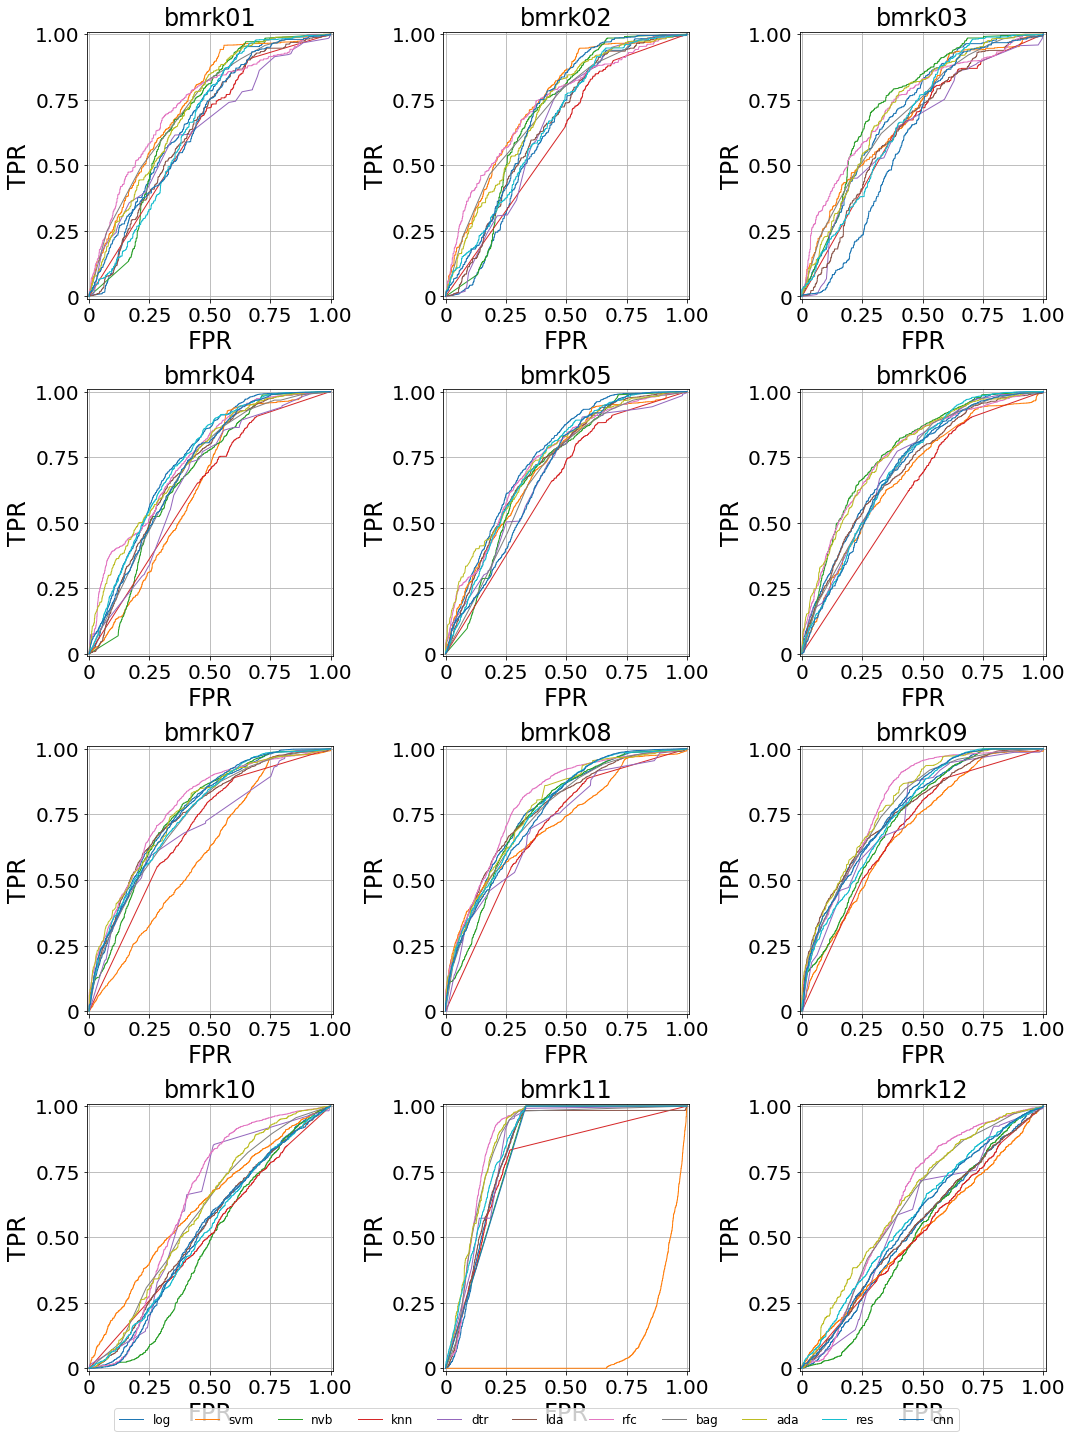

In [21]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(15, 20)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        for mkey in ml_keys:
            fpr_list= res_dict_tst_feat[mkey]["fpr_list"][iterator]
            tpr_list = res_dict_tst_feat[mkey]["tpr_list"][iterator]
            ax[ii, jj].plot(fpr_list, tpr_list, '-', linewidth = 1.0)
        ax[ii, jj].set_title(f'{pat_key}', fontsize = 24)
        ax[ii, jj].set_xlabel('FPR', fontsize = 24)
        ax[ii, jj].set_ylabel('TPR', fontsize = 24)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 20)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 24)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 20)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    print()
    print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(ml_keys, loc = 8, ncol=len(ml_keys),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "mlspred_roc_curves_feat_v01.jpg", dpi=300)
    #plt.savefig(fname = "fig03_roc_curves_v01.jpg", dpi=300)
    plt.show()


ROC curves:


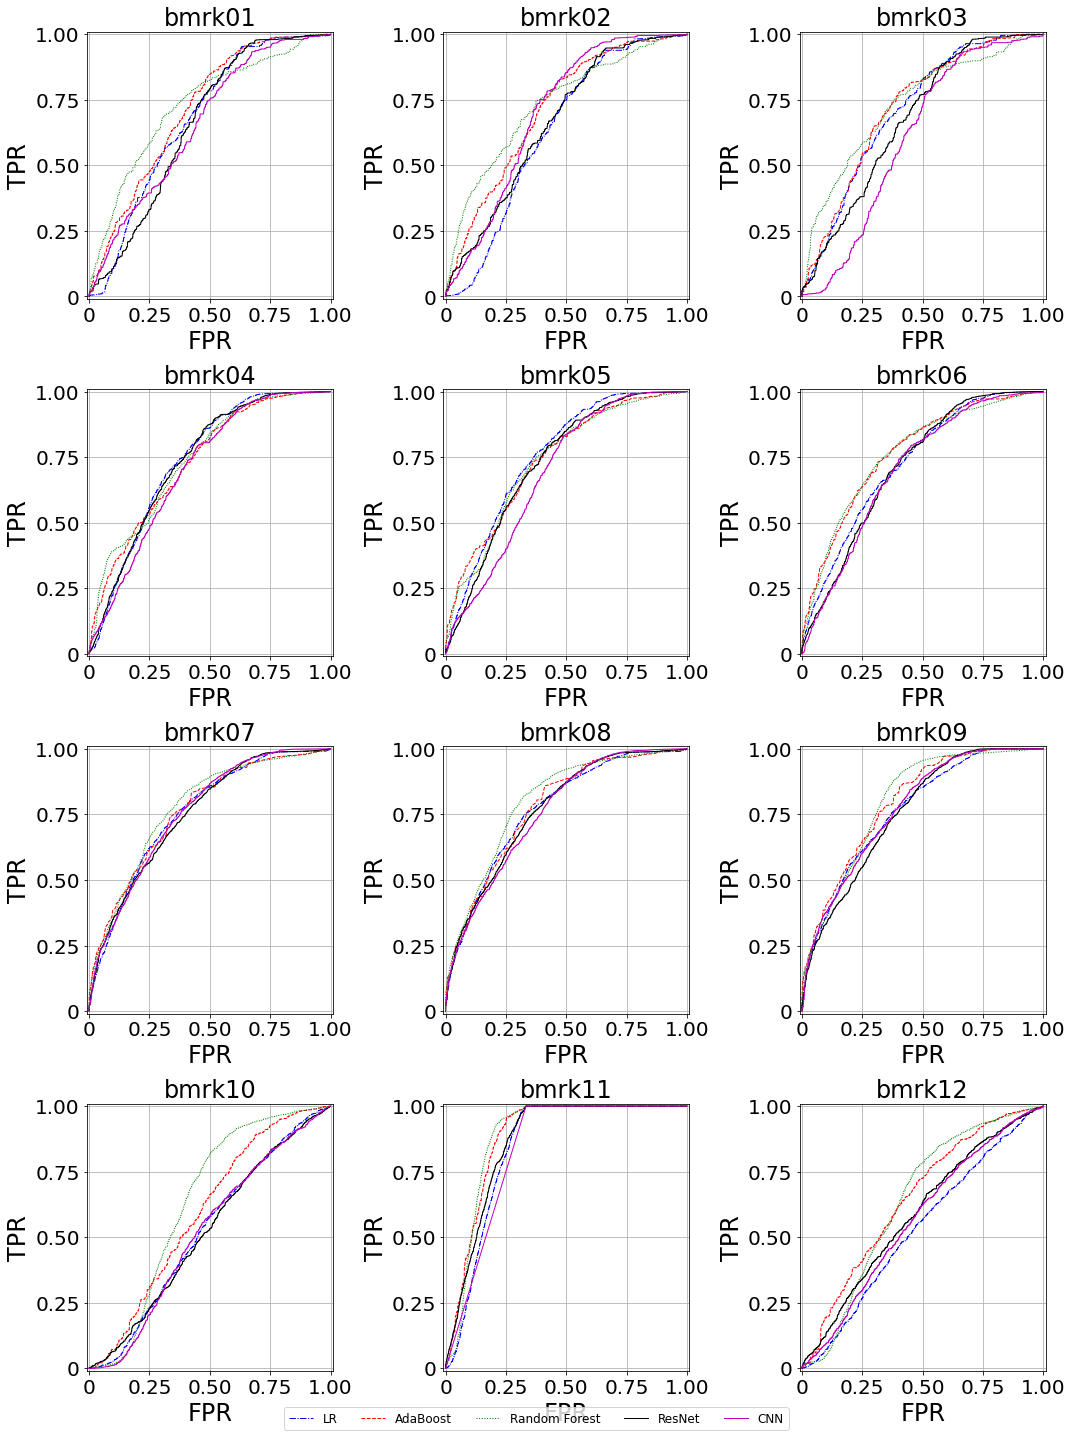

In [22]:
select_keys = {"log": "LR", "ada": "AdaBoost", "rfc": "Random Forest", "res": "ResNet", "cnn": "CNN"}
style_keys = {"log": "b-.", "ada": "r--", "rfc": "g:", "res": "k-", "cnn": "m-"}
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(15, 20)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        for mkey in select_keys.keys():
            fpr_list= res_dict_tst_feat[mkey]["fpr_list"][iterator]
            tpr_list = res_dict_tst_feat[mkey]["tpr_list"][iterator]
            ax[ii, jj].plot(fpr_list, tpr_list, style_keys[mkey], linewidth = 1.0)
        ax[ii, jj].set_title(f'{pat_key}', fontsize = 24)
        ax[ii, jj].set_xlabel('FPR', fontsize = 24)
        ax[ii, jj].set_ylabel('TPR', fontsize = 24)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 20)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 20)
        ax[ii, jj].grid()
    print()
    print("ROC curves:")
    plt.figlegend(select_keys.values(), loc = 8, ncol=5, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.0, 0.5, 0.5),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "mlspred_roc_curves_feat_v01.jpg", dpi=300)
    plt.show()